# 캐글 경진대회 따라해보기

## 최종 결과

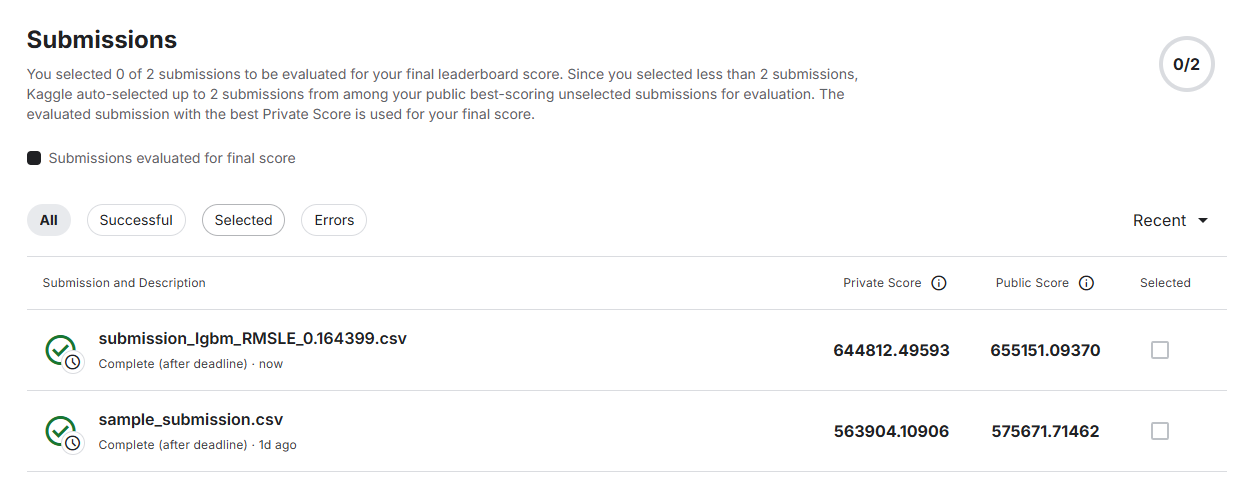

## 모델

In [1]:
import os
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV

In [2]:
import xgboost
import lightgbm
import missingno
import sklearn

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print(xgboost.__version__)
print(lightgbm.__version__)
print(missingno.__version__)
print(sklearn.__version__)

/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


1.4.2
3.3.0
0.5.0
1.0


- 사용할 라이브러리 불러오기

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
# hint : os.getenv를 사용하거나 직접 경로를 작성

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


- 데이터 불러오기
- trainset과 test셋으로 나누기

In [4]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

- 데이터 형태 확인

## 데이터 전처리
- date 바꾸기
- id 없애기
- 치우친 컬럼 로그 변환하기  


**나중에 test도 바꿔야헤!!**

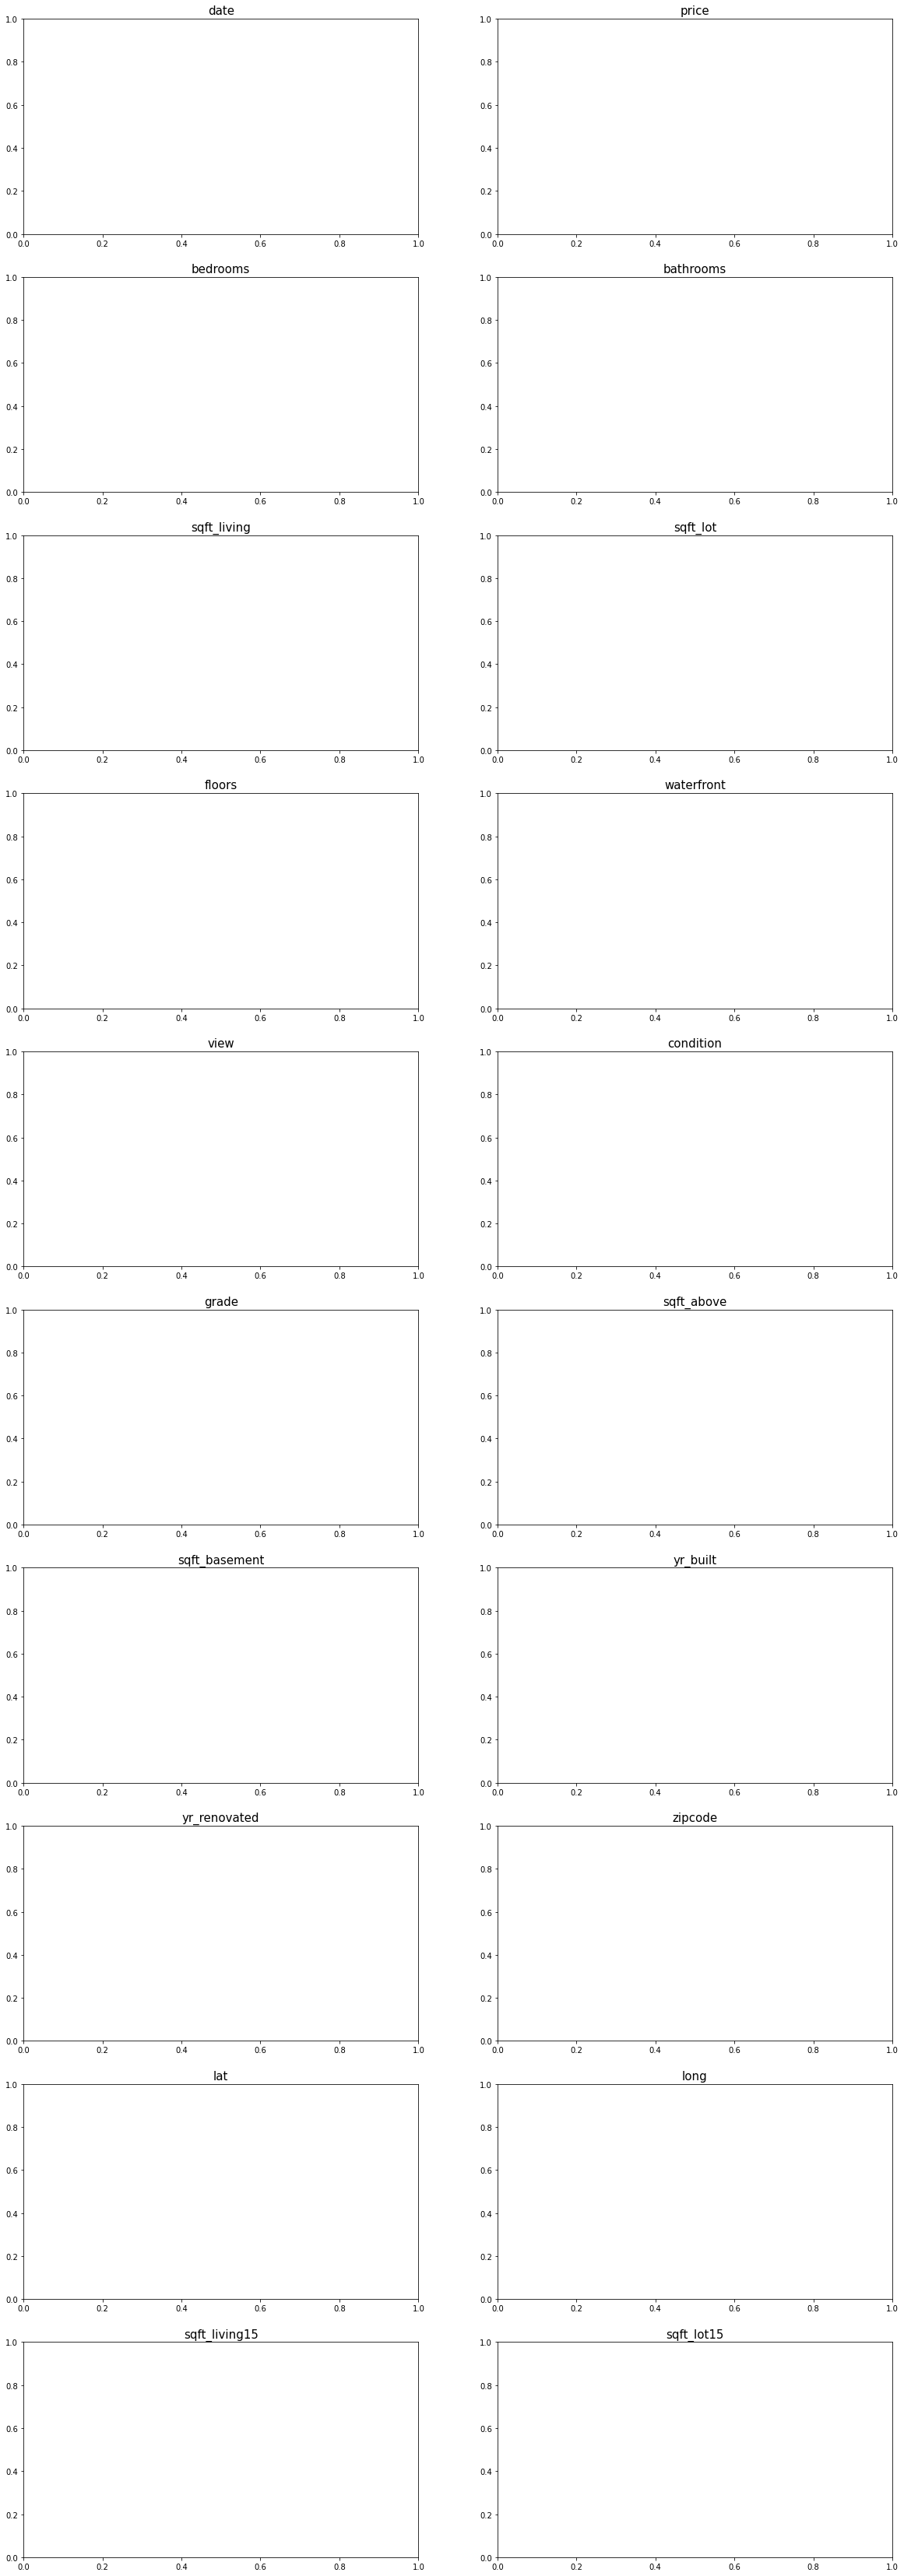

In [8]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

count = 1
columns = train.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(train=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 21 :
            break

- 각 변수들의 분포 확인

In [9]:
y = train['price']

- train에 있는 price를 y에 넣기

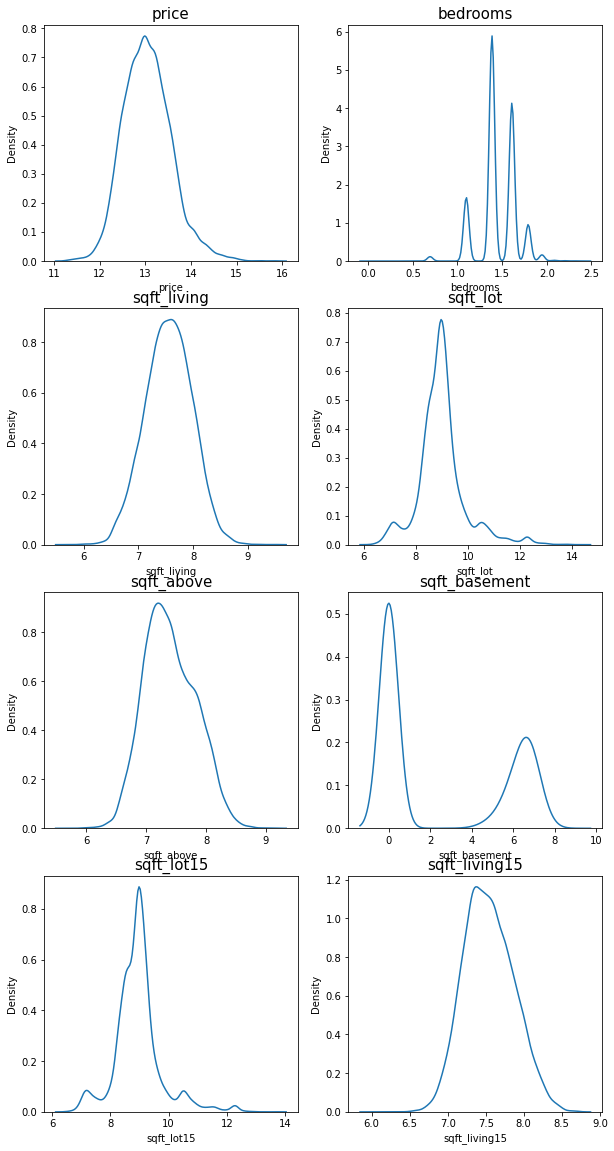

In [10]:
skew_columns = ['price', 'bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    
y = np.log1p(y)

fig, ax = plt.subplots(4, 2, figsize=(10, 20))

count = 0
for row in range(4):
    for col in range(2):
        if count < len(skew_columns):
            sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
            ax[row][col].set_title(skew_columns[count], fontsize=15)
            count += 1

- train에 있는 칼럼을 로그 변환한다
- y에 있는 price 로그 변환
- 내가 보기에는 price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_lot15, sqft_living15 이렇게 7개가 한쪽으로 치우쳐 보인다

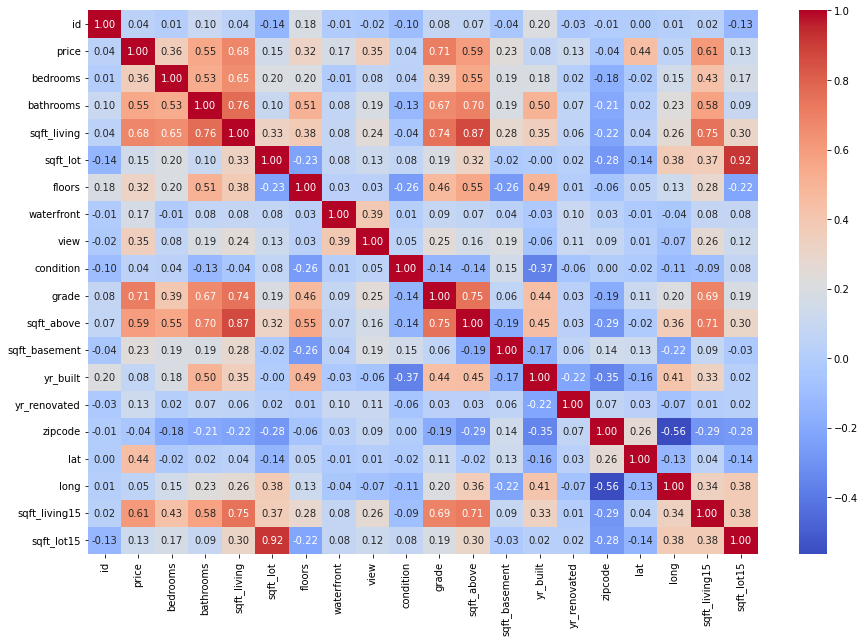

In [11]:
corr_matrix = train.corr()

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corr_matrix, fmt='.2f', annot=True, cmap='coolwarm', ax=ax)

plt.show()

- **date**
    - 상관계수가 낮다. 계절에 따라 달라질 수 있으니 확인해보자
- **sqft_lot**
    - 땅 크기가 중요하지 않다고 하는데, 땅보다는 집 크기가 중요하니까 낮을 수 있을 것 같다
- **conditon**
    - 집 상태는 중요하다고 생각하는데 왜 관계가 없다고 하지..?
- **yr_bulit**
    - 집 지은 년도도 중요하지 않나? 확인이 필요할 것 같다
- **zipcode**
    - 우편번호는 없어도 될 것 같다
- **long**
    - 경도는 중요하지 않다고 한다. 위도는 중요하다고 하는데 동서 방향은 크게 의미가 없나?
- **sqft_lot15**
    - 이것도 땅 크기인데 sqft랑 마찬가지로 땅 크기는 크게 중요하지 않을 것 같다

In [12]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

del train['price']
del train['id']
del train['long']
del train['zipcode']
del train['sqft_lot']
del train['sqft_lot15']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront',
       'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'lat', 'sqft_living15'],
      dtype='object')


- 필요없는 컬럼 제거

In [13]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']
del test['long']
del test['zipcode']
del test['sqft_lot']
del test['sqft_lot15']
print('완료')

완료


- test 데이터셋 천처리

In [14]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('완료')

완료


- RMSE 계산을 위한 함수

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=42)

random_state=2020
print('완료')

완료


- train, test 데이터셋 분리
- random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.

In [16]:
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]
print('완료')

완료


- 모델 불러오기

In [17]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [18]:
param_grid = {
    'num_leaves': [100, 300, 500],  # 최대 잎의 수
    'max_depth': [1, 10],  # 트리의 최대 깊이
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'n_estimators': [50, 100],  # 부스팅 스텝의 수
}
model = LGBMRegressor(random_state=random_state)

- 하이퍼 파라미터 설정

In [30]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = xgb.XGBRegressor(random_state=random_state)
lightgbm = lgb.LGBMRegressor(n_estimators = 300, max_depth=10, learning_rate= 0.1, random_state=random_state)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [31]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(train.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=train.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

In [32]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8537
Model: XGBoost, CV score:0.8562
Model: LightGBM, CV score:0.8659


- 모델 성능 확인

In [33]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [34]:
y_pred = AveragingBlending(models, train, y, test)
print(len(y_pred))
y_pred = np.expm1(y_pred)
y_pred

6468


array([13.57479562, 13.5901636 , 14.46590463, ..., 13.78541033,
       13.58490708, 13.7276569 ])

In [35]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [36]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.164399')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv saved!
